# Animal species recognition using CNN and Resnet50

## CNN

### Open files and find animal species

In [1]:
import numpy
import sys
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt 
from glob import glob
%matplotlib inline
numpy.set_printoptions(threshold=sys.maxsize)

train = pd.read_csv('train.csv') # read train set file
test = pd.read_csv('test.csv') # read test set file

all_labels = train.Animal 
all_labels.isnull().any()
no_dupes = train.Animal.unique() # remove duplicates

print('Amount of species: {}'.format(train.Animal.unique().shape[0]))
print ()
print (no_dupes)

Amount of species: 30

['hippopotamus' 'squirrel' 'grizzly+bear' 'ox' 'german+shepherd' 'buffalo'
 'otter' 'bobcat' 'wolf' 'persian+cat' 'collie' 'antelope' 'seal'
 'dalmatian' 'siamese+cat' 'moose' 'horse' 'killer+whale' 'mouse' 'walrus'
 'beaver' 'rhinoceros' 'chimpanzee' 'weasel' 'spider+monkey' 'raccoon'
 'rat' 'chihuahua' 'mole' 'bat']


In [2]:
pd.read_csv('train.csv', nrows=10) # what train data looks like

,Image_id,Animal
0,Img-1.jpg,hippopotamus
1,Img-2.jpg,squirrel
2,Img-3.jpg,grizzly+bear
3,Img-4.jpg,ox
4,Img-5.jpg,german+shepherd
5,Img-6.jpg,buffalo
6,Img-7.jpg,otter
7,Img-8.jpg,bobcat
8,Img-9.jpg,wolf
9,Img-10.jpg,persian+cat


In [3]:
pd.read_csv('test.csv', nrows=10) # what test data looks like

,Image_id
0,Img-1.jpg
1,Img-2.jpg
2,Img-3.jpg
3,Img-4.jpg
4,Img-5.jpg
5,Img-6.jpg
6,Img-7.jpg
7,Img-8.jpg
8,Img-9.jpg
9,Img-10.jpg


In [4]:
print (train.shape[0]) # amount of files in training set
print (test.shape[0]) # amount of files in test set
all_labels.isnull().any() # check for null values

13000
6000


False

In [5]:
amount_animals = pd.value_counts(train.Animal) # count amount of animals per species 
print (amount_animals)

horse              1111
squirrel            808
antelope            695
german+shepherd     687
collie              680
seal                665
buffalo             606
grizzly+bear        583
otter               519
ox                  501
persian+cat         491
chimpanzee          477
rhinoceros          477
moose               476
hippopotamus        464
bobcat              418
wolf                403
chihuahua           386
dalmatian           359
raccoon             346
siamese+cat         341
bat                 256
rat                 220
killer+whale        193
spider+monkey       189
weasel              184
walrus              148
beaver              133
mouse               124
mole                 60
Name: Animal, dtype: int64


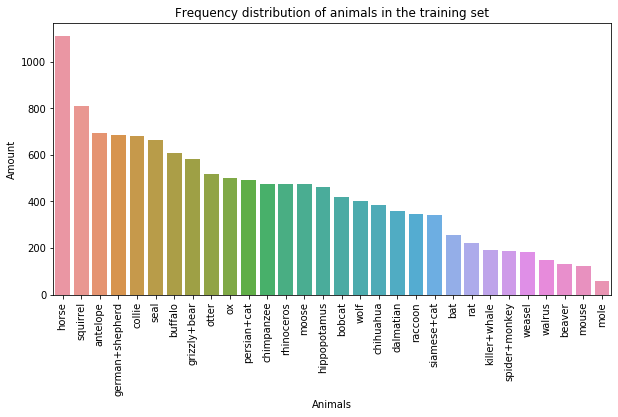

In [6]:
plt.figure(figsize=(10, 5))
figure = sns.barplot(x=amount_animals.index, y=amount_animals.values)
figure.set_xticklabels(figure.get_xticklabels(), rotation= 90)
figure.set_title('Frequency distribution of animals in the training set')
figure.set(xlabel='Animals', ylabel='Amount')
plt.show() # plot frequency distribution

In [7]:
TRAIN_PATH = '/Users/varishaganesh/Machine Learning/train/train/'
TEST_PATH = '/Users/varishaganesh/Machine Learning/test/test/'

In [8]:
import cv2
from PIL import Image
from tqdm import tqdm

def read_img(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (224, 224))
    return img

train_img = []

for img_path in tqdm(train.Image_id.values):
    train_img.append(read_img(TRAIN_PATH + img_path))

100%|██████████| 13000/13000 [04:29<00:00, 48.16it/s]


In [9]:
import gc

In [10]:
import numpy as np
X_train = np.array(train_img, np.float32) / 255.

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
lb = LabelEncoder()
lb.fit(train.Animal.values)
y = lb.transform(train.Animal.values)

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(X_train, y, test_size=0.15, random_state=47)

In [15]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [16]:
ytrain = np_utils.to_categorical(ytrain)
yvalid = np_utils.to_categorical(yvalid)

In [17]:
model = Sequential()
model.add(BatchNormalization(input_shape = Xtrain.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.15))

model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(Conv2D(128, kernel_size=(3, 3), activation= 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(30, activation='softmax'))

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 218, 218, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 109, 109, 64)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 109, 109, 64)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 107, 107, 128)    

In [19]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
early_stops = EarlyStopping(patience=5, monitor='val_acc')
checkpointer = ModelCheckpoint(filepath='weights.best.eda.hdf5', verbose=1, save_best_only=True)


In [1]:
model.fit(Xtrain, ytrain, validation_data=(Xvalid, yvalid), epochs=2, batch_size=16, verbose=1)

NameError: name 'model' is not defined

In [ ]:
model.save_weights('weights.best.eda.hdf5')

## Test set prediction

In [ ]:
test_img = []
for img_path in tqdm(test.Image_id.values):
    test_img.append(read_img(TEST_PATH + img_path))

In [ ]:
X_test = np.array(test_img, np.float32)/255.

In [ ]:
y_test_pred = model.predict(X_test)

In [ ]:
subm = pd.DataFrame()
subm['image_id'] = test.Image_id
label_df = pd.DataFrame(data=y_test_pred, columns=lb.classes_)

In [ ]:
subm = pd.concat([subm, label_df], axis=1)

In [ ]:
subm.to_csv('submission.csv', index=False)